# PS1-1 Linear Classifiers (logistic regression and GDA)

In [24]:
import numpy as np
import src.util as util
from src.linear_model import LinearModel
from matplotlib import pyplot as plt

In [25]:
# set paths
ds1_train_path = './data/ds1_train.csv'
ds1_valid_path = './data/ds1_valid.csv'
ds2_train_path = './data/ds2_train.csv'
ds2_valid_path = './data/ds2_valid.csv'
p01b_pred_path_1 = './output/p01b_pred_1.txt'
p01b_pred_path_2 = './output/p01b_pred_2.txt'
p01e_pred_path_1 = './output/p01e_pred_1.txt'
p01e_pred_path_2 = './output/p01e_pred_2.txt'

### (a) Prove $J(\theta)$ for logitic regression is convex.

Compute $\frac{\partial J(\theta)}{\partial \theta_i}$ according to the chain rule:

\begin{equation}\notag
\begin{aligned}
            \frac{\partial J(\theta)}{\partial \theta_i}&=-\frac{1}{m}\sum_{k=1}^m\left[y^{(k)}\frac{g'\left(\theta^Tx^{(k)}\right)}{g\left(\theta^Tx^{(k)}\right)}x_i^{(k)}+\left(1-y^{(k)}\right)\frac{-g'\left(\theta^Tx^{(k)}\right)}{1-g\left(\theta^Tx^{(k)}\right)}x_i^{(k)}\right]\\
            &=-\frac{1}{m}\sum_{k=1}^m\left[x_i^{(k)}\left(y^{(k)}-g\left(\theta^Tx^{(k)}\right)\right)\right].
        \end{aligned}
\end{equation}

Therefore, the Hessian of $J(\theta)$ is:

\begin{equation}\notag
\begin{aligned}
            H_{ij}=\frac{\partial^2J(\theta)}{\partial\theta_i\partial\theta_j}=\frac{1}{m}\sum_{k=1}^m\left[x_i^{(k)}x_j^{(k)}g\left(\theta^Tx^{(k)}\right)\left(1-g\left(\theta^Tx^{(k)}\right)\right)\right].
        \end{aligned}
\end{equation}

Assume $\theta \in \mathbb{R}^n$, then $H$ is a $n \times n$ matrix. For any $z\in\mathbb{R}^n$,

\begin{equation}\notag
\begin{aligned}
 z^THz&=\begin{bmatrix}
               z_1&z_2&\cdots&z_n
           \end{bmatrix}\begin{bmatrix}
               H_{11}&H_{12}&\cdots&H_{1n}\\
               H_{21}&H_{22}&\cdots&H_{2n}\\
               \vdots&\vdots&&\vdots\\
               H_{n1}&H_{n2}&\cdots&H_{nn}
           \end{bmatrix}
           \begin{bmatrix}
               z_1\\
               z_2\\
               \vdots\\
               z_n
           \end{bmatrix}\\
           &=\sum_{j=1}^nz_j\sum_{i=1}^nz_iH_{ij}\\
           &=\sum_{j=1}^n\sum_{i=1}^nz_jz_i\left[\frac{1}{m}\sum_{k=1}^mx_j^{(k)}x_i^{(k)}g\left(\theta^Tx^{(k)}\right)\left(1-g\left(\theta^Tx^{(k)}\right)\right)\right]\\
           &=\frac{1}{m}\sum_{k=1}^m\left(\sum_{i=1}^n\sum_{j=1}^nz_ix_i^{(k)}x_j^{(k)}z_j\right)g\left(\theta^Tx^{(k)}\right)\left(1-g\left(\theta^Tx^{(k)}\right)\right)\\
           &=\frac{1}{m}\sum_{k=1}^m\left(\left(x^{(k)}\right)^Tz\right)^2g\left(\theta^Tx^{(k)}\right)\left(1-g\left(\theta^Tx^{(k)}\right)\right)\\
           &\ge0.
\end{aligned}
\end{equation}

Besides, $H^T=H$. Therefore, $H \succeq 0$.

### (b) Implement logistic regression.

In [26]:
class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        def h(theta, x):
            """
            Compute hypothesis function $h\\_\\theta(x) = sigmoid(x\\theta)$.
            
            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).

            Returns:
                $h\\_\\theta(x)$ of shape (m,)
            """
            return 1 / (1 + np.exp(-np.matmul(x, theta.reshape(-1, 1))))
        

        def gradient(theta, x, y):
            """
            Compute gradient of $J(\\theta)$, i.e., $\\nabla\\_\\thetaJ(\\theta)$.

            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).
                y: Training example labels. Shape (m,).

            Returns:
                Output of shape (n, )
            """
            res = x * (y.reshape(-1, 1) - h(theta, x))
            return -res.mean(axis=0)
        
        def hessian(theta, x):
            """
            Compute Hessian matrix of $J(\\theta)$.

            Args:
                theta: model parameters. Shape (n,).
                x: Training example inputs. Shape (m, n).
                y: Training example labels. Shape (m,).

            Returns:
                Output of shape (n, n)
            """
            x1 = x[:, :, np.newaxis]    # shape (m, n, 1)
            x2 = x[:, np.newaxis, :]    # shape (m, 1, n)
            res = np.matmul(x1, x2) # shape (m, n, n)
            prob = h(theta, x)  # shape (m,)
            prob = prob.reshape(-1, 1, 1)   # shape (m, 1, 1)
            res = res * prob * (1 - prob)
            return res.mean(axis=0)
        
        # run Newton's Method to find theta where grad = 0
        # thus minimize J(\theta)
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])
        grad = gradient(self.theta, x, y)
        while(np.max(np.abs(grad)) >= self.eps):
            # print('Current gradient of J(theta) is', grad)
            # print('Current J(theta) is', -(y * np.log(h(self.theta, x)).squeeze(1) + \
            #                             (1 - y) * np.log(1 - h(self.theta, x)).squeeze(1)).mean())
            H = hessian(self.theta, x)
            H_inv = np.linalg.inv(H)
            self.theta = self.theta - np.matmul(H_inv, grad)
            grad = gradient(self.theta, x, y)
        # print('gradient of J(\\theta) is', grad)
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return 1 / (1 + np.exp(-np.matmul(x, self.theta.reshape(-1, 1))))
        # *** END CODE HERE ***


Fit and predict on dataset 1.

In [27]:
ds1_x_train, ds1_y_train = util.load_dataset(ds1_train_path, add_intercept=True)

In [28]:
ds1_lr_clf = LogisticRegression()
ds1_lr_clf.fit(ds1_x_train, ds1_y_train)

In [29]:
ds1_x_val, ds1_y_val = util.load_dataset(ds1_valid_path, add_intercept=True)
y_pred = ds1_lr_clf.predict(ds1_x_val).reshape(-1)
np.savetxt(p01b_pred_path_1, y_pred)

In [30]:
def acc(y_pred, label):
    res = ((y_pred >= 0.5) == (label))
    return res[res == True].shape[0] / label.shape[0]

In [31]:
# compute acc on training set
y_pred_train = ds1_lr_clf.predict(ds1_x_train).reshape(-1)
print("Train acc is", acc(y_pred_train, ds1_y_train))

# compute acc on validation set
print("Val acc is", acc(y_pred, ds1_y_val))

Train acc is 0.8825
Val acc is 0.9


Repeat on dataset 2.

In [32]:
ds2_lr_clf = LogisticRegression()
ds2_x_train, ds2_y_train = util.load_dataset(ds2_train_path, add_intercept=True)
ds2_lr_clf.fit(ds2_x_train, ds2_y_train)

# evaluate
ds2_x_val, ds2_y_val = util.load_dataset(ds2_valid_path, add_intercept=True)
y_pred = ds2_lr_clf.predict(ds2_x_val).reshape(-1)
np.savetxt(p01b_pred_path_2, y_pred)

# compute acc on training set
y_pred_train = ds2_lr_clf.predict(ds2_x_train).reshape(-1)
print("Train acc is", acc(y_pred_train, ds2_y_train))

# compute acc on validation set
print("Val acc is", acc(y_pred, ds2_y_val))

Train acc is 0.915
Val acc is 0.91


### (c) Prove GDA results in a classifier that has a linear decision boundary.

Compute posterior probability by Bayes' Rule:

\begin{equation}\notag
\begin{aligned}
    P(y=1|x;\phi, \mu_0, \mu_1, \Sigma)&=\frac{P(x|y=1;\mu_1,\Sigma)P(y=1;\phi)}{P(x|y=1;\mu_1,\Sigma)P(y=1;\phi)+P(x|y=0;\mu_0,\Sigma)P(y=0;\phi)}\\
    &=\frac{1}{1 + \frac{P(x|y=0;\mu_0,\Sigma)P(y=0;\phi)}{P(x|y=1;\mu_1,\Sigma)P(y=1;\phi)}}\\
    &=\frac{1}{1 + \frac{1-\phi}{\phi}\exp{\left\{\frac{1}{2}\left((x-\mu_1)^T\Sigma^{-1}(x-\mu_1)-(x-\mu_0)^T\Sigma^{-1}(x-\mu_0)\right)\right\}}}\\
    &=\frac{1}{1 + \frac{1-\phi}{\phi}\exp{\left\{\frac{1}{2}\left(2(\Sigma^{-1}(\mu_0-\mu_1))^{T}x+\mu_1^T\Sigma^{-1}\mu_1-\mu_0^T\Sigma^{-1}\mu_0\right)\right\}}}\\
    &=\frac{1}{1 + \exp{\left\{(\Sigma^{-1}(\mu_0-\mu_1))^{T}x+\frac{1}{2}(\mu_1^T\Sigma^{-1}\mu_1-\mu_0^T\Sigma^{-1}\mu_0)+\ln{(\frac{1-\phi}{\phi})}\right\}}}.
\end{aligned}
\end{equation}

On the other hand, $ P(y=1|x;\phi, \mu_0, \mu_1, \Sigma)=\frac{1}{1+\exp{\left(-(\theta^Tx + \theta_0)\right)}}$.

Therefore, $\theta=\Sigma^{-1}(\mu_1-\mu_0),\theta_0=\frac{1}{2}(\mu_0^T\Sigma^{-1}\mu_0-\mu_1^T\Sigma^{-1}\mu_1)-\ln{(\frac{1-\phi}{\phi})}$.

### (d) Fit GDA parameters $\phi, \mu_0, \mu_1, \Sigma$ using the training set.

Here we assume $n=1$, thus the PDF of $x|y$ is

\begin{equation}\notag
\begin{aligned}
    p(x|y=k)=\frac{1}{\sqrt{2\pi\Sigma}}\exp{\left(-\frac{(x-\mu_k)^2}{2\Sigma}\right)}, k\in\{0,1\}.
\end{aligned}
\end{equation}

Thus, the log-likelihood is
\begin{equation}\notag
\begin{aligned}
    l(\phi, \mu_0, \mu_1, \Sigma)&=\ln \prod_{i=1}^m p\left(x^{(i)}|y^{(i)};\mu_0,\mu_1,\Sigma^2\right)p\left(y^{(i)};\phi\right)\\
    &=m\ln\left(\frac{1}{\sqrt{2\pi\Sigma}}\right) + \sum_{i=1}^m\left(-\frac{(x-\mu_{y^{(i)}})^2} {2\Sigma}\right) + \sum_{i=1}^m {y^{(i)}}\ln\phi + \sum_{i=1}^m {(1-y^{(i)})}\ln(1-\phi).
\end{aligned}
\end{equation}

Next, we compute the partial derivatives of $l$ w.r.t. $\phi, \mu_0, \mu_1, \Sigma$.

\begin{equation}\notag
\begin{aligned}
    \frac{\partial l}{\partial \phi}&=\sum_{i=1}^m\left(\frac{y^{(i)}}{\phi}+\frac{y^{(i)}-1}{1-\phi}\right)\\
    \frac{\partial l}{\partial \mu_0}&=\sum_{i=1}^m\left(\frac{(x^{(i)}-\mu_0)1\{y^{(i)}=0\}}{\Sigma}\right)\\
    \frac{\partial l}{\partial \mu_1}&=\sum_{i=1}^m\left(\frac{(x^{(i)}-\mu_1)1\{y^{(i)}=1\}}{\Sigma}\right)\\
    \frac{\partial l}{\partial \Sigma}&=-\frac{m}{2\Sigma} + \sum_{i=1}^m \left(\frac{(x-\mu_{y^{(i)}})^2} {2\Sigma^2}\right)
\end{aligned}
\end{equation}

Then let the partial derivatives equal to zero, we can get the MLE result of $\phi, \mu_0, \mu_1, \Sigma$:

\begin{equation}\notag
\begin{aligned}

\phi&=\frac{1}{m}\sum_{i=1}^my^{(i)}=\frac{1}{m}\sum_{i=1}^m 1\{y^{(i)}=1\}\\\
\mu_0&=\frac{\sum_{i=1}^m x^{(i)}1\{y^{(i)}=0\}}{\sum_{i=1}^m 1\{y^{(i)}=0\}}\\
\mu_1&=\frac{\sum_{i=1}^m x^{(i)}1\{y^{(i)}=1\}}{\sum_{i=1}^m 1\{y^{(i)}=1\}}\\
\Sigma&=\frac{1}{m}\sum_{i=1}^m (x^{(i)}-\mu_{y^{(i)}})^2

\end{aligned}
\end{equation}

### (e) Implement GDA.

In [33]:
class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m, n = x.shape
        phi = y[y==1.0].shape[0] / m       # shape (1,)
        mu_0 = x[y==0, :].mean(axis=0).reshape(n, 1)   # shape (n, 1)
        mu_1 = x[y==1, :].mean(axis=0).reshape(n, 1)   # shape (n, 1)
        vec_0 = x - mu_0.T    # shape (m, n)
        vec_1 = x - mu_1.T    # shape (m, n)
        vec = np.where(y.reshape(m, -1) == 1, vec_1, vec_0)    # shape (m, n)
        sigma = vec.reshape(m, n, 1) @ vec.reshape(m, 1, n)   # shape (m, n, n)
        sigma = np.mean(sigma, axis=0)  # shape (n, n)
        inv_sigma = np.linalg.inv(sigma)
        self.theta = inv_sigma @ (mu_1 - mu_0) # shape(n, 1)
        self.theta_0 = 1 / 2 * (mu_0.T @ inv_sigma @ mu_0 - mu_1.T @ inv_sigma @ mu_1) - \
                        - np.log((1 - phi) / phi)   # (1,)
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        return 1 / (1 + np.exp(-(x @ self.theta + self.theta_0)))
        # *** END CODE HERE

Fit and predict on dataset 1.

In [34]:
ds1_x_train, ds1_y_train = util.load_dataset(ds1_train_path, add_intercept=False)
ds1_gda_clf = GDA()
ds1_gda_clf.fit(ds1_x_train, ds1_y_train)

# evaluate
ds1_x_val, ds1_y_val = util.load_dataset(ds1_valid_path, add_intercept=False)
y_pred = ds1_gda_clf.predict(ds1_x_val).reshape(-1)
np.savetxt(p01e_pred_path_1, y_pred)

# compute acc on training set
y_pred_train = ds1_gda_clf.predict(ds1_x_train).reshape(-1)
print("Train acc is", acc(y_pred_train, ds1_y_train))

# compute acc on validation set
print("Val acc is", acc(y_pred, ds1_y_val))

Train acc is 0.86625
Val acc is 0.83


Repeat on dataset 2.

In [35]:
ds2_x_train, ds2_y_train = util.load_dataset(ds2_train_path, add_intercept=False)
ds2_gda_clf = GDA()
ds2_gda_clf.fit(ds2_x_train, ds2_y_train)

# evaluate
ds2_x_val, ds2_y_val = util.load_dataset(ds2_valid_path, add_intercept=False)
y_pred = ds2_gda_clf.predict(ds2_x_val).reshape(-1)
np.savetxt(p01e_pred_path_2, y_pred)

# compute acc on training set
y_pred_train = ds2_gda_clf.predict(ds2_x_train).reshape(-1)
print("Train acc is", acc(y_pred_train, ds2_y_train))

# compute acc on validation set
print("Val acc is", acc(y_pred, ds2_y_val))

Train acc is 0.91375
Val acc is 0.91


### (f) Plot decision boundaries of logistic regression and GDA on dataset 1

In [36]:
# rewrite .src.utils.plot to plot decision boundaries of logistic regression 
# and GDA at the same time

def plot(x, y, lr_theta, gda_theta, lr_line_color, gda_line_color, save_path=None, correction=1.0, 
         title='Dataset1-Train', lr_legend='Logistic Regression', gda_legend='GDA'):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        lr_theta: Vector of parameters for logistic regression model.
        gda_theta: Vector of parameters for GDA model.
        line_color: Color of the decision boundary line.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
        title: figure title.
        lr_legend: legend for decision boundary of logistic regression
        gda_legend: legend for decision boundary of gda
    """
    # Plot dataset
    plt.figure(figsize=(8, 6))
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2_lr = -(lr_theta[0] / lr_theta[2] * correction + lr_theta[1] / lr_theta[2] * x1)
    x2_gda = -(gda_theta[0] / gda_theta[2] * correction + gda_theta[1] / gda_theta[2] * x1)
    plt.plot(x1, x2_lr, c=lr_line_color, linewidth=2, label=lr_legend)
    plt.plot(x1, x2_gda, c=gda_line_color, linewidth=2, label=gda_legend)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)
    plt.title(title)
    plt.legend()

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    plt.close()

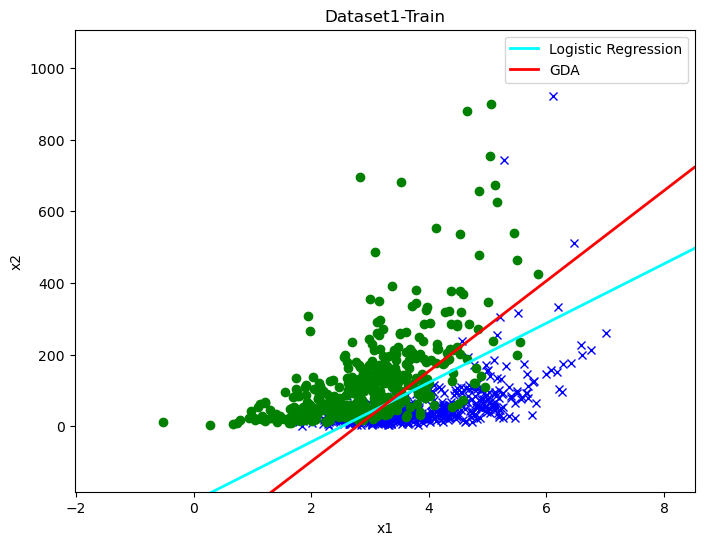

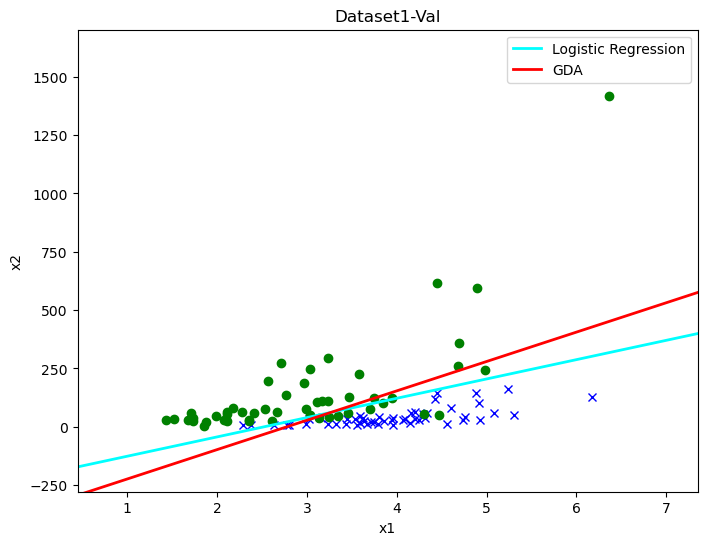

In [37]:
plot(ds1_x_train, ds1_y_train, 
     ds1_lr_clf.theta, 
     np.concatenate((ds1_gda_clf.theta_0.reshape(-1, 1), ds1_gda_clf.theta), axis=0),
     lr_line_color='cyan', 
     gda_line_color='red', 
     save_path='./output/p01_plot_ds1_train.png', correction=1.0)

plot(ds1_x_val, ds1_y_val, 
     ds1_lr_clf.theta, 
     np.concatenate((ds1_gda_clf.theta_0.reshape(-1, 1), ds1_gda_clf.theta), axis=0),
     lr_line_color='cyan', 
     gda_line_color='red', 
     save_path='./output/p01_plot_ds1_val.png', correction=1.0,
     title='Dataset1-Val',
     )

### (g) Repeat (f) on dataset 2

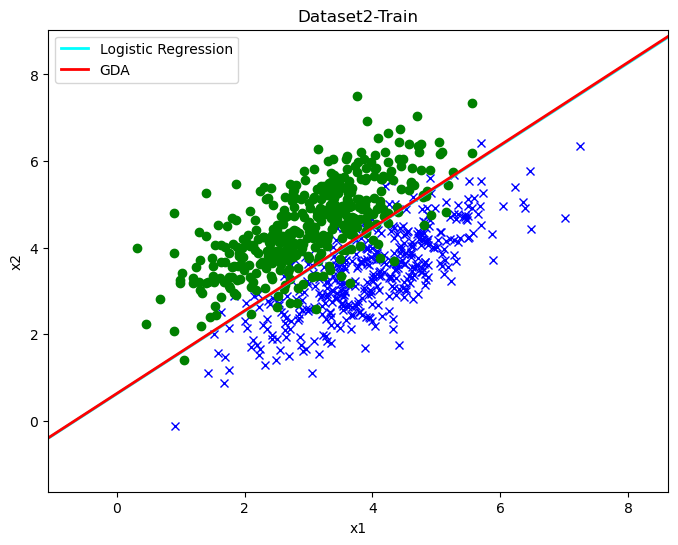

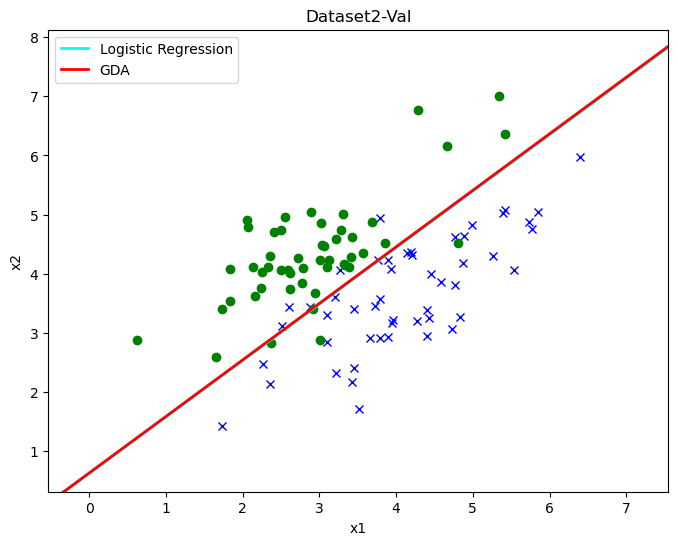

In [38]:
plot(ds2_x_train, ds2_y_train, 
     ds2_lr_clf.theta, 
     np.concatenate((ds2_gda_clf.theta_0.reshape(-1, 1), ds2_gda_clf.theta), axis=0),
     lr_line_color='cyan', 
     gda_line_color='red', 
     save_path='./output/p01_plot_ds2_train.png', correction=1.0,
     title='Dataset2-Train',
     )

plot(ds2_x_val, ds2_y_val, 
     ds2_lr_clf.theta, 
     np.concatenate((ds2_gda_clf.theta_0.reshape(-1, 1), ds2_gda_clf.theta), axis=0),
     lr_line_color='cyan', 
     gda_line_color='red', 
     save_path='./output/p01_plot_ds2_val.png', correction=1.0,
     title='Dataset2-Val',
     )

GDA performs worse than logistic regression on dataset 1, since the data in dataset 1 is not sampled from Gaussian distribution (e.g., $x_2$ seems to be sampled from an exponential distribution, thus the joint distribution of $(x_1, x_2)$ is not Gaussian).

### (h) Optimize GDA on dataset 1

Plot distribution of $x_{\{1,2\}}|y=0$ and $x_{\{1,2\}}|y=1$ to check which 
feature is not sampled from Gaussian distribution.

In [39]:
def plot_hist(x, y):
    """Plot histograms of x1 and x2 conditioned on y=0 and y=1."""
    x1_y0 = x[y == 0, -2]
    x2_y0 = x[y == 0, -1]
    x1_y1 = x[y == 1, -2]
    x2_y1 = x[y == 1, -1]
    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].hist(x1_y0), ax[0].set_title('x1 | y=0')
    ax[1].hist(x1_y1), ax[1].set_title('x1 | y=1')
    ax[2].hist(x2_y0), ax[2].set_title('x2 | y=0')
    ax[3].hist(x2_y1), ax[3].set_title('x2 | y=1')
    plt.tight_layout()
    plt.show()

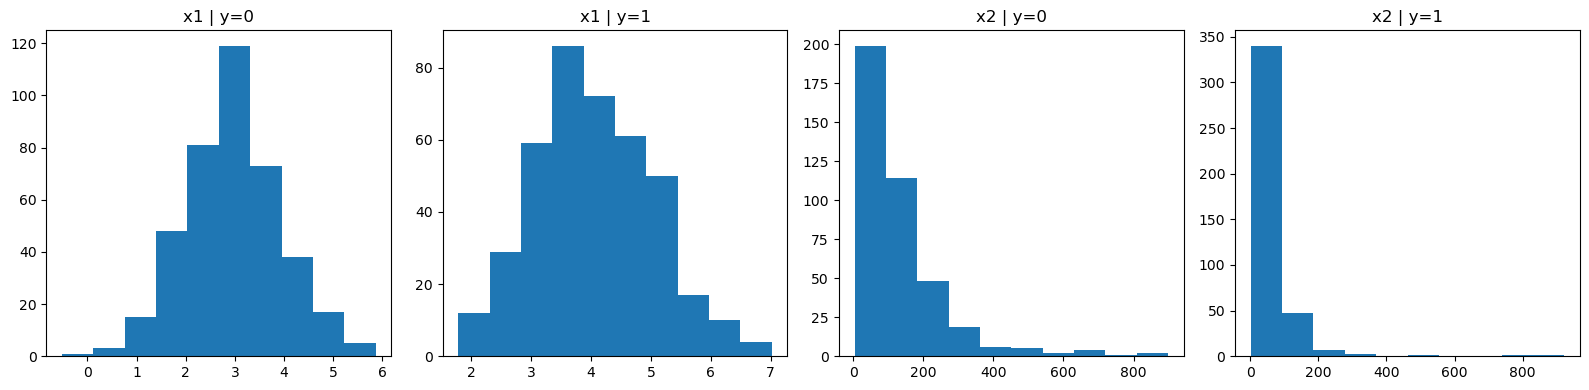

In [40]:
plot_hist(ds1_x_train, ds1_y_train)

Now we can see that $x_2$ is not sampled from Gaussian distribution and it's all positive. To make it more Gaussian-like, we can apply a log transformation on $x_2$.

In [41]:
ds1_x_train[:, -1] = np.log(ds1_x_train[:, -1])
ds1_x_val[:, -1] = np.log(ds1_x_val[:, -1])

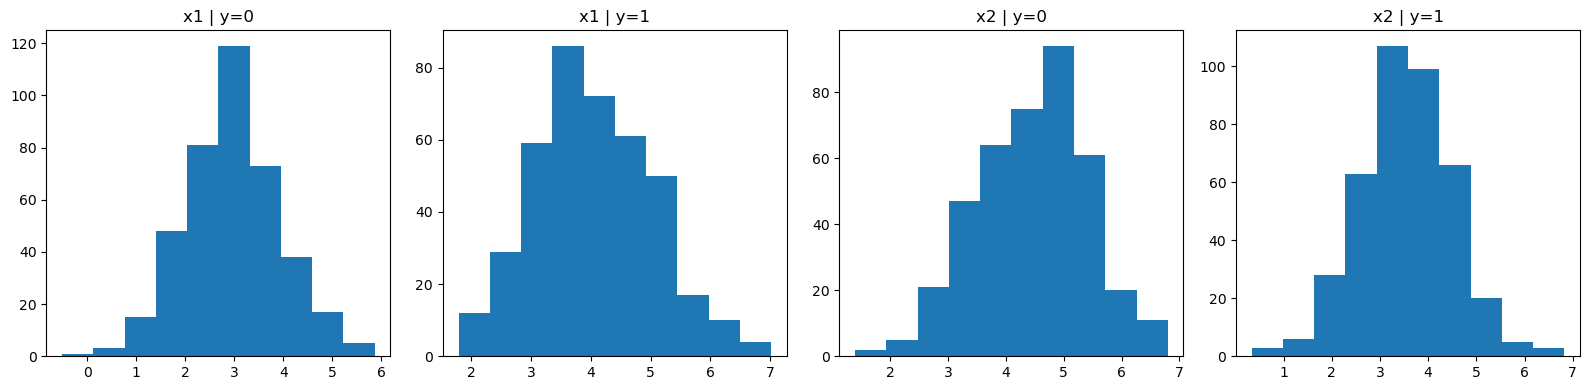

In [42]:
plot_hist(ds1_x_train, ds1_y_train)

Then perform GDA on dataset 1 with log-transformed $x_2$.

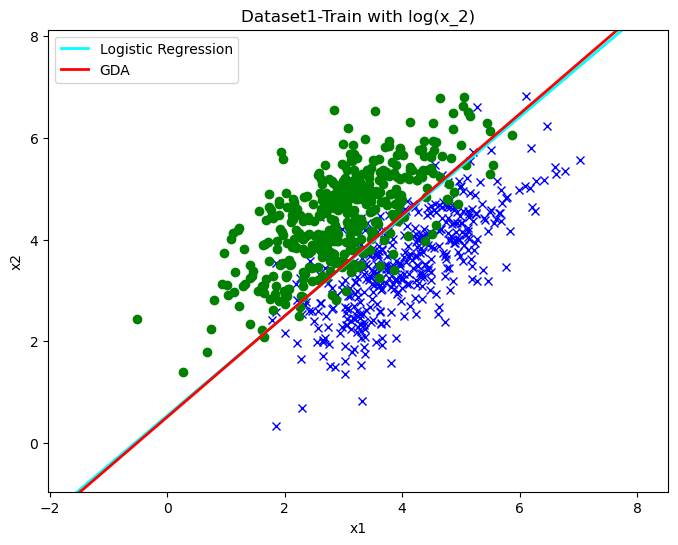

In [43]:
gda_clf = GDA()
gda_clf.fit(ds1_x_train, ds1_y_train)
lr_clf = LogisticRegression()
lr_clf.fit(util.add_intercept(ds1_x_train), ds1_y_train)
plot(ds1_x_train, ds1_y_train, 
     lr_clf.theta, 
     np.concatenate((gda_clf.theta_0.reshape(-1, 1), gda_clf.theta), axis=0),
     lr_line_color='cyan', 
     gda_line_color='red', 
     save_path='./output/p01_plot_ds1_train_log.png', correction=1.0,
     title='Dataset1-Train with log(x_2)',
)

As we see, GDA gots similar decision boundary to logistic regression on dataset 1 after the log transformation.